# Molecular Dynamics Time Series

This notebook will import data from a molecular dynamics simulation (which was performed using [hoomd-blue](https://hoomd-blue.readthedocs.io/en/stable/index.html), but any positional data of particles suffices) and infers model equations.

## Importing MD data

We start off by importing the time series data, this includes the time stamps, domain size $(L_x, L_y)$ and $(x, y, z)$ coordinates of every particle for every time step. (As of now only 2D simulations are supported, so providing a $z$ component isn't strictly necessary as it gets replaced with zero entries anyway, but for the sake of generality it is included here.)
  For the code that generated the actual simulation see this [repository](https://zivgitlab.uni-muenster.de/o_mai001/dissipative-particles/-/tree/master). Do note that the file is rather large.

In [1]:
import numpy as np
import urllib.request, json

In [2]:
link = "https://zivgitlab.uni-muenster.de/o_mai001/dissipative-particles/-/raw/master/data/trajectories/2d_binary_mixture.json"

with urllib.request.urlopen(link) as url:
    data = json.load(url)

In [3]:
time = np.array(data["time"])
box = np.array(data["box"])
positions = np.array(data["positions"])

## Converting positions to density
The package wraps methods of either `freud-analysis` or `sklearn` to generate a density profile from the positions:

In [4]:
# from tsme.utils.density import density_from_2d_positions_sklearn
from tsme.utils.density import density_from_2d_positions_freud

In [5]:
# density = density_from_2d_positions_sklearn(box, positions, bandwidth=2.0, bins=[128, 128])
density = density_from_2d_positions_freud(box, positions, width=128, r_max=7.5)
sol = np.array([density])

Gaussian density estimation using Freud: 100%|██████████| 800/800 [00:40<00:00, 19.76it/s]


In [6]:
%%capture
from tsme.utils.visualization import animate
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.axis("off")
anima = animate(sol, fig=fig, ax=ax)
plt.close(fig)

In [7]:
from IPython import display
# display.HTML(anima.to_jshtml())
display.HTML(anima.to_html5_video())

## Infer differential equations

In [8]:
from tsme.model_estimation.model import Model

In [9]:
estimated_model = Model(sol, time, phys_domain=[[0, box[0]], [0, box[1]]])
estimated_model.init_library(3, 4)
estimated_model.print_library()

|   Index | Term                          |   Value 0 |
|---------|-------------------------------|-----------|
|       0 | 1.0                           |         0 |
|       1 | u[0]                          |         0 |
|       2 | u[0]*u[0]                     |         0 |
|       3 | u[0]*u[0]*u[0]                |         0 |
|       4 | d_dx(u[0],1)                  |         0 |
|       5 | d_dy(u[0],1)                  |         0 |
|       6 | d_dx(u[0]*u[0],1)             |         0 |
|       7 | d_dy(u[0]*u[0],1)             |         0 |
|       8 | d_dx(u[0]*u[0]*u[0],1)        |         0 |
|       9 | d_dy(u[0]*u[0]*u[0],1)        |         0 |
|      10 | d_dx(u[0],2)                  |         0 |
|      11 | d_dy(u[0],2)                  |         0 |
|      12 | dd_dxdy(u[0],(1,1))           |         0 |
|      13 | d_dx(u[0]*u[0],2)             |         0 |
|      14 | d_dy(u[0]*u[0],2)             |         0 |
|      15 | dd_dxdy(u[0]*u[0],(1,1))      |     

In [10]:
estimated_model.optimize_sigma(error="BIC", backend="hyperopt", max_evals=20, space="log")

Generating library functions (this may take some time)...
100%|██████████| 20/20 [35:18<00:00, 105.93s/trial, best loss: 6888.473908674974]
Optimal threshold(s) found: {'t0': 0.026771322157888407}
New Sigma set to: 

|   Index | Term                   |      Value 0 |
|---------|------------------------|--------------|
|       2 | u[0]*u[0]              |  0.000624127 |
|       3 | u[0]*u[0]*u[0]         | -0.000308173 |
|      13 | d_dx(u[0]*u[0],2)      | -0.00570342  |
|      14 | d_dy(u[0]*u[0],2)      | -0.000724981 |
|      16 | d_dx(u[0]*u[0]*u[0],2) |  0.00279133  |
|      17 | d_dy(u[0]*u[0]*u[0],2) |  0.00113505  |
|      36 | d_dx(u[0]*u[0],4)      | -0.000381726 |
|      37 | d_dy(u[0]*u[0],4)      |  9.51134e-05 |


In [11]:
t = estimated_model.time
sol_est = estimated_model.simulator.simulate([t[0], t[-1]], method="DOP853", t_eval=t)

IVP: 1000.0ut [02:18,  7.23ut/s]                                          


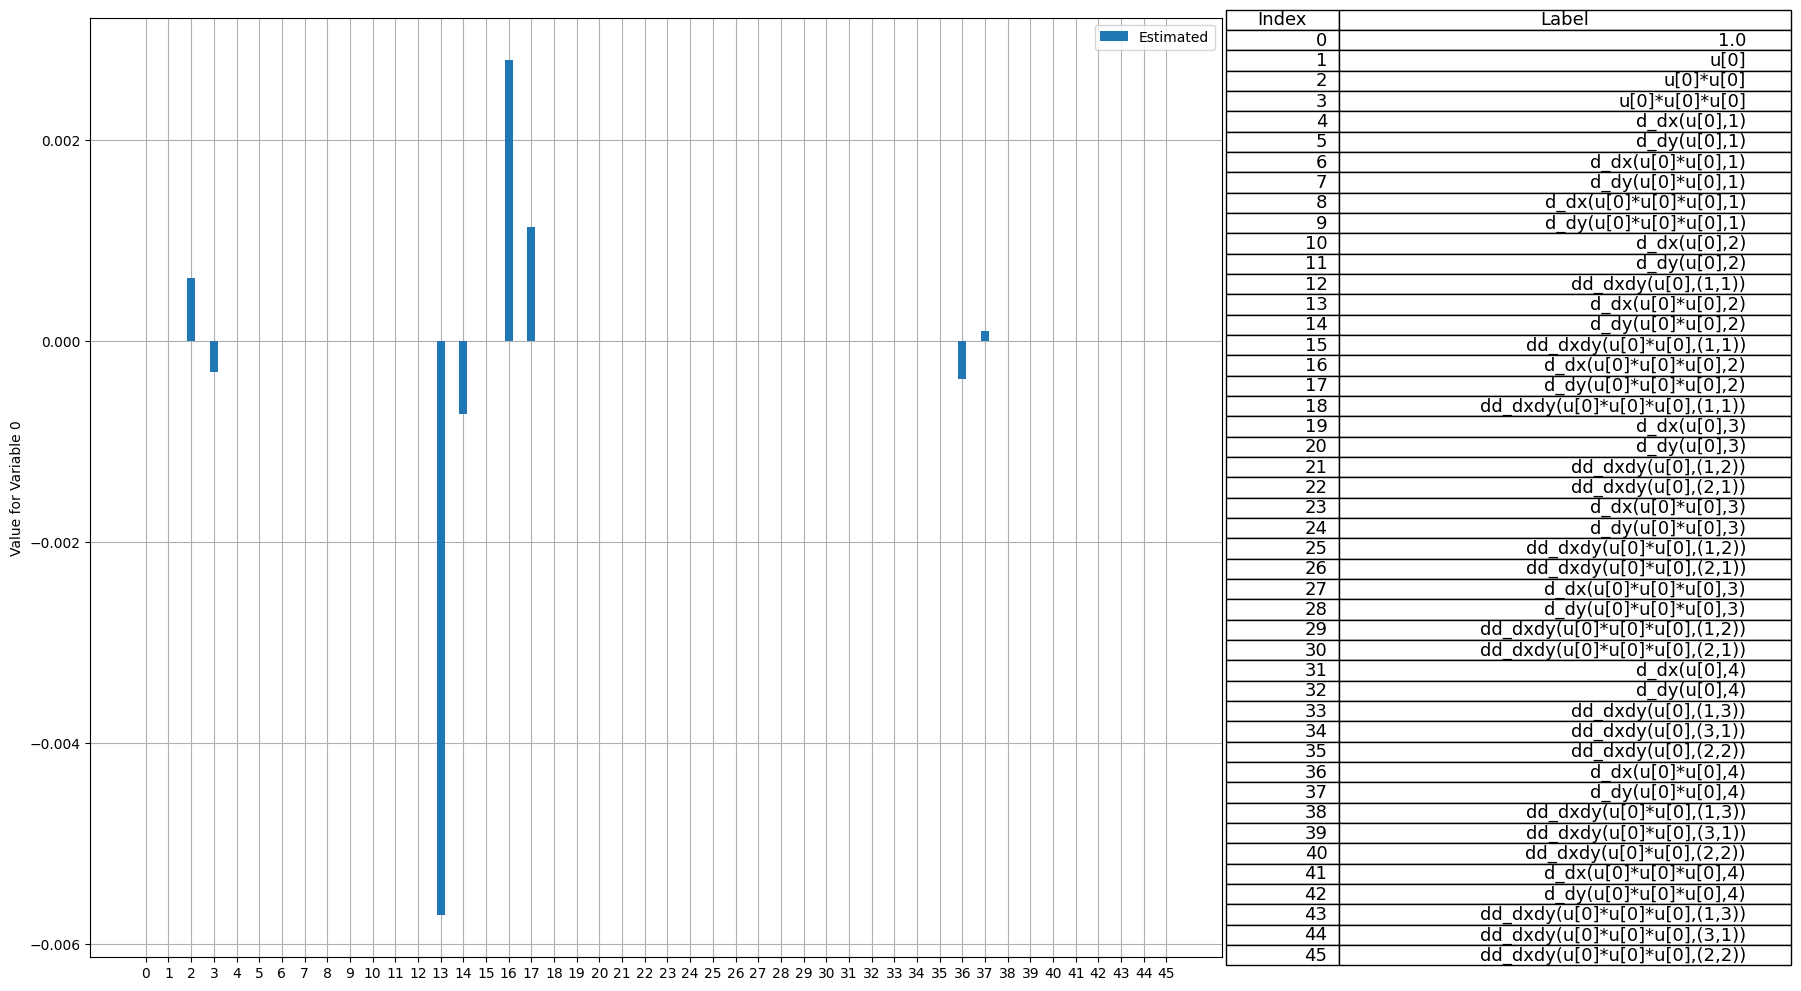

In [12]:
from tsme.utils.visualization import barplot_parameters

sigma = estimated_model.sigma

labels = estimated_model.print_strings
barplot_parameters(sigma, labels=labels, figsize=(18, 10), table_fontsize=13)

## Modifying the library

In [13]:
estimated_model.drop_library_terms([1, 2, 3, 13, 14])
estimated_model.add_library_terms(["self.diff.div(u[0]**2, 2)"])

User-Warning: Library is being modified after simulator is initiated. Simulator is being discarded.


In [14]:
estimated_model.print_library()

|   Index | Term                          |   Value 0 |
|---------|-------------------------------|-----------|
|       0 | 1.0                           |         0 |
|       1 | d_dx(u[0],1)                  |         0 |
|       2 | d_dy(u[0],1)                  |         0 |
|       3 | d_dx(u[0]*u[0],1)             |         0 |
|       4 | d_dy(u[0]*u[0],1)             |         0 |
|       5 | d_dx(u[0]*u[0]*u[0],1)        |         0 |
|       6 | d_dy(u[0]*u[0]*u[0],1)        |         0 |
|       7 | d_dx(u[0],2)                  |         0 |
|       8 | d_dy(u[0],2)                  |         0 |
|       9 | dd_dxdy(u[0],(1,1))           |         0 |
|      10 | dd_dxdy(u[0]*u[0],(1,1))      |         0 |
|      11 | d_dx(u[0]*u[0]*u[0],2)        |         0 |
|      12 | d_dy(u[0]*u[0]*u[0],2)        |         0 |
|      13 | dd_dxdy(u[0]*u[0]*u[0],(1,1)) |         0 |
|      14 | d_dx(u[0],3)                  |         0 |
|      15 | d_dy(u[0],3)                  |     

In [15]:
estimated_model.init_simulator()
estimated_model.sequential_threshold_ridge(lamb=0.0, thres=0.002)

Generating library functions (this may take some time)...
New Sigma set to: 

|   Index | Term                          |     Value 0 |
|---------|-------------------------------|-------------|
|       0 | 1.0                           |  0          |
|       1 | d_dx(u[0],1)                  |  0          |
|       2 | d_dy(u[0],1)                  | -0.00378816 |
|       3 | d_dx(u[0]*u[0],1)             |  0          |
|       4 | d_dy(u[0]*u[0],1)             |  0          |
|       5 | d_dx(u[0]*u[0]*u[0],1)        |  0          |
|       6 | d_dy(u[0]*u[0]*u[0],1)        |  0          |
|       7 | d_dx(u[0],2)                  |  0          |
|       8 | d_dy(u[0],2)                  |  0.00261552 |
|       9 | dd_dxdy(u[0],(1,1))           |  0.00358648 |
|      10 | dd_dxdy(u[0]*u[0],(1,1))      |  0          |
|      11 | d_dx(u[0]*u[0]*u[0],2)        |  0.0100113  |
|      12 | d_dy(u[0]*u[0]*u[0],2)        |  0.0110987  |
|      13 | dd_dxdy(u[0]*u[0]*u[0],(1,1)) |  0      

In [16]:
estimated_model.init_library(0, 0)